### AlphaPilot - Predict Gate Regions

In [1]:
'''
TODO
[ ] process data
    [x] upload imgs
    [ ] upload labels
        [x] truth_new.json upload
        [ ] figure out which truth dataset
        [ ]
    [ ] unzip data
    [ ] find old processing script
        [ ] eliminate 9th data point (?)
    [ ] align number of labels with number of images
    
    
[ ] Build ImagePoint data set

[ ] Packaging / sourcing
    [ ] git between cloud and local
    [ ] run the processing on both

'''
pass

In [62]:
import os, sys, json, copy, random
import pandas as pd
import numpy as np
from fastai.vision import *

In [63]:
from fastai.utils.mem import  gpu_mem_get_free_no_cache

In [64]:
gpu_mem_get_free_no_cache()

7176

In [65]:
#cloud
data_dir = Path('data/alphapilot/')

zip_fn = data_dir/'Data_Training.zip'
raw_fn = data_dir/'data_training'
label_fn = data_dir/'truth_new.json'

#local
if os.name == 'nt':
    
    data_dir = Path('../../../../alphapilot/')
    
    #from os.getcwd() == files/fastai/course-v3/nbs/custom
    zip_fn = data_dir/'Data_Training.zip'
    raw_fn = data_dir/'Data_Training/Data_Training/'
    label_fn = data_dir/'truth_new.json'

##### Build Data on Cloud

In [66]:
if os.name != 'nt' and False:
    
    # this didnt work cant have variable for shebang line
    # !unzip str(zip_fn) str(raw_fn)
    
    # this didnt work need to correct with cp
    !unzip data/alphapilot/Data_Training.zip  data/alphapilot

##### Build fastai object with y-data "ground truth"
modelers given in json file with img name and truth

truth_new.json contains all manually revised and corrected bbox's

there are only 5381 corrected labels for 9339 training images.

there are 5827 non-blank bbox correct images, these are in truth_1dim (dict) and truth_df (DF)

In [67]:
with open(label_fn, 'r') as f:
    truth = json.load(f)

print('truth:', *list(truth.items())[:2], sep='\n')

list_blanks = [k for k,v in truth.items()
                 if len(v[0]) == 0]

print('\nall blank images: ', list_blanks)

truth_1dim = {k:v[0] for k,v in truth.items() 
                      if k not in list_blanks
             }

print('\ntruth_1dim:', *list(truth_1dim.items())[:2], sep='\n')

print( '\ndifference in length: '
       ,len(list(truth.items())) 
       ,len(list(truth_1dim.items()))
     )

truth:
('IMG_9622.JPG', [[583, 439, 772, 431, 779, 628, 582, 631]])
('IMG_9925.JPG', [[481, 295, 769, 268, 777, 590, 480, 589]])

all blank images:  ['IMG_1343.JPG', 'IMG_0688.JPG', 'IMG_6608.JPG', 'IMG_0492.JPG']

truth_1dim:
('IMG_9622.JPG', [583, 439, 772, 431, 779, 628, 582, 631])
('IMG_9925.JPG', [481, 295, 769, 268, 777, 590, 480, 589])

difference in length:  5831 5827


In [68]:
truth_df = pd.DataFrame(truth_1dim)

In [69]:
truth_df.T.head()

,0,1,2,3,4,5,6,7
IMG_9622.JPG,583,439,772,431,779,628,582,631
IMG_9925.JPG,481,295,769,268,777,590,480,589
IMG_6733.JPG,593,362,650,399,649,597,589,592
IMG_4583.JPG,477,292,722,278,723,560,479,549
IMG_0401.JPG,522,321,657,344,650,554,519,569


In [70]:
'''
Questions:

- how does the label-data in head-pose setup / how is it imported?
   - 15K training images, 500 validation images
   - data.valid_dl.y.get(i).data -> e.g. tensor([[ 0.0297, -0.0363]])
   - 
- does fastai.bbox allow no rect, e.g. polygons?


Definitions:

.filter_by_func() - what I'm looking for to reduce the x-data

PointsLabelList - applies the transform 

                    .get(i) return the points scaled

PointsProcessor sets LabelList.c = number of distinct points to target

ImagePoints - "Support applying transforms to a `flow` of points."
        
                    y_first=True (by default)

ImageBBox

ImgList - 
                    imglist.train.x.get(i) - returns data at i
                    imglist.train.x.items[i] - returns path pointer to img at i

Example of coords in head-pose:

['0.637035 0.0358445 -0.770001 \n',
 '0.152652 0.973268 0.171598 \n',
 '0.755569 -0.226856 0.614534 \n',
 '\n',
 '215.355 36.4714 894.197 \n',
 '\n']

'''
pass

##### Build FastAI objects

we want to do a reprocducible validation, and test split here

we want to align with only truth_new.json object, and only those with non-blank bbox

PointsItemList <- PointsLabelList(y) + ImageList(x)

In [111]:
# build the master class PointsItemList
gate_data = PointsItemList.from_folder(raw_fn)

In [112]:
gate_data.label_cls

fastai.vision.data.PointsLabelList

In [113]:
#filter the records without a corrected, or a blank ground truth

TRUTH_INDS  = list(truth_df.columns)
def filter_img_by_truth(fn):
    return fn.name in TRUTH_INDS

filter_records = filter_img_by_truth

len0 = len(gate_data)

gate_data.filter_by_func(filter_records)

len1 = len(gate_data)

print('dataset reduced from len: %i to len: %i' % (len0, len1))

dataset reduced from len: 9339 to len: 5827


In [114]:
#split the data into train/validation
np.random.seed(42)
#set torch variable here or what?

gate_data = gate_data.split_by_rand_pct(valid_pct=0.2)

print('num records in train: %i ; and in validation: %i' 
      % (len(gate_data.train.items), len(gate_data.valid.items)))

num records in train: 4662 ; and in validation: 1165


In [115]:
b_batch_mod = False
if b_batch_mod:
    
    def remove_two(fn):
        if fn.name not in ('IMG_2971.JPG', 'IMG_8623 (1).JPG'):
            return True
        return False
    
    my_filter_2 = remove_two
    
    len0 = len(gate_data.train)
    gate_data.train.filter_by_func(my_filter_2)
    len1 = len(gate_data.train)
    
    print(len0, len1, len1 % 4)

In [99]:
# gate_data

In [93]:
# data_final.get_label_cls(data_final.valid_dl.y.items)
data_final.get_label_cls(gate_data.valid)

fastai.vision.data.PointsLabelList

In [98]:
# data_final

In [95]:
# my_labels = gate_data.label_from_func(label_points )

In [96]:
# my_labels

In [97]:
# gate_data

In [116]:
# build label data from json into dataset
def label_points(fn):
    '''
        input:  x0,y0,...x3,y3 (list)
        output: [y0,x0],...[y3,x3] (list) 
         
        >use y_first=True in label-load-func
    '''
    p = truth_df[fn.name]
    return tensor([ [ float(p[i*2+1]), float(p[i*2+0]) ] for i in range(4)])

gate_data = gate_data.label_from_func(label_points, )

##### Verify the Data Matches via plots
look for red '+' in the corners of the gate

IMG_8623 (1).JPG
tensor([[486., 584.],
        [473., 657.],
        [613., 661.],
        [615., 586.]])


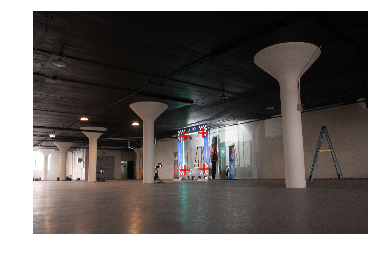

In [101]:
i = 1

fn =  gate_data.train.x.items[i]
img = gate_data.train.x.get(i)
pts = gate_data.train.y.items[i]

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

print(fn.name)
print(pts)
img.show(y=get_ip(img, pts), figsize=(6, 6), c='r', marker='+', s=100, hide_axis=False)

##### Normalize the dataset
we can experiment with different parameters here

In [117]:
img0 = gate_data.train.x.get(0)
img0.shape

torch.Size([3, 864, 1296])

In [118]:
def mod_img_divisor(h,w):
    return [ i for i in range(2, min(h,w) // 2) 
               if (h % i ==0) and (w % i ==0 )
           ]
divisors = mod_img_divisor(*list(img0.shape)[1:])

[tensor(img0.shape[1:]) / e for e in divisors]

[tensor([432, 648]),
 tensor([288, 432]),
 tensor([216, 324]),
 tensor([144, 216]),
 tensor([108, 162]),
 tensor([ 96, 144]),
 tensor([ 72, 108]),
 tensor([54, 81]),
 tensor([48, 72]),
 tensor([36, 54]),
 tensor([32, 48]),
 tensor([24, 36]),
 tensor([18, 27]),
 tensor([16, 24]),
 tensor([12, 18]),
 tensor([ 8, 12]),
 tensor([6, 9]),
 tensor([4, 6])]

In [119]:
(864 / 108), (1296 / 162)

(8.0, 8.0)

In [122]:
gate_data.tfms, gate_data.tfmargs

(None, {})

In [125]:
my_transforms = get_transforms()
my_transforms[0][:2]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True)]

In [126]:
gate_data = gate_data.transform(get_transforms()
                                ,tfm_y=True
                                ,size=(108,162)
                                ,remove_out=False
                               )    

In [129]:
str(gate_data.tfms)[:30], '\n', gate_data.tfmargs

('[RandTransform(tfm=TfmCrop (cr',
 '\n',
 {'size': (108, 162), 'remove_out': False})

In [130]:
batch_size = 4

gate_bunch = gate_data.databunch(bs=batch_size)

assert isinstance(gate_bunch, ImageDataBunch)

In [131]:
data_final = gate_bunch.normalize(imagenet_stats)

assert isinstance(data_final, ImageDataBunch)

In [132]:
data_final

ImageDataBunch;

Train: LabelList (4662 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: data/alphapilot/data_training;

Valid: LabelList (1165 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: data/alphapilot/data_training;

Test: None

In [133]:
gpu_mem_get_free_no_cache()

7176

##### Do checks on data to understand collate error

In [134]:
assert data_final.batch_size == batch_size == 4

In [51]:
tx = [(i, v) for i,v in enumerate(data_final.train_dl.items)
             if list(data_final.train_dl.x.get(i).shape) != [3, 864, 1296] 
     ]

In [52]:
tx

[]

In [53]:
vx = [(i, v) for i,v in enumerate(data_final.valid_dl.items)
             if list(data_final.valid_dl.x.get(i).shape) != [3, 864, 1296] 
     ]

In [54]:
vx

[]

In [60]:
data_final.batch_size

4

In [62]:
len(data_final.train_dl.x.items)

4662

In [64]:
data_final.train_dl.x.items[:2]

array([PosixPath('data/alphapilot/data_training/IMG_2971.JPG'),
       PosixPath('data/alphapilot/data_training/IMG_8623 (1).JPG')], dtype=object)

In [84]:
#check y-tensor-szie
trainy = data_final.train_dl.y.items
ty_size = [list(e.shape) for e in trainy]
wrong = [e for e in ty_size if e != [4,2]]
print(wrong)

validy = data_final.valid_dl.y.items
vy_size = [list(e.shape) for e in validy]
wrong = [e for e in ty_size if e != [4,2]]
print(wrong)

[]

In [29]:
idx = next(iter(data_final.train_dl.batch_sampler))
samples = [data_final.train_ds[i] for i in idx]
shapes = [[o[i].data.shape for o in samples] for i in range(2)]
shapes

[[torch.Size([3, 108, 162]),
  torch.Size([3, 108, 162]),
  torch.Size([3, 108, 162]),
  torch.Size([3, 108, 162])],
 [torch.Size([4, 2]),
  torch.Size([4, 2]),
  torch.Size([4, 2]),
  torch.Size([4, 2])]]

In [30]:
data_final

ImageDataBunch;

Train: LabelList (4660 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: data/alphapilot/data_training;

Valid: LabelList (1165 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: data/alphapilot/data_training;

Test: None

In [89]:
data_final.train_dl.collate_fn()

In [90]:
samples

[(Image (3, 108, 162), ImagePoints (108, 162)),
 (Image (3, 108, 162), ImagePoints (108, 162)),
 (Image (3, 108, 162), ImagePoints (108, 162)),
 (Image (3, 108, 162), ImagePoints (108, 162))]

In [27]:
for elem in data_final.train_dl:
    my_elem = elem
    break
    
my_elem

(tensor([[[[-1.5122, -1.5218, -1.5294,  ..., -0.2299, -0.1803, -0.1476],
           [-1.5059, -1.4965, -1.5241,  ..., -0.2039, -0.1323, -0.0870],
           [-1.5828, -1.5384, -1.6047,  ..., -0.1766, -0.1142, -0.0655],
           ...,
           [ 1.2900,  1.4160,  1.5193,  ..., -0.7763, -0.7469, -0.7448],
           [ 1.2845,  1.2952,  1.2466,  ..., -0.7741, -0.7687, -0.7438],
           [ 1.2808,  1.2984,  1.3335,  ..., -0.7165, -0.7154, -0.7384]],
 
          [[-1.4165, -1.4270, -1.4341,  ..., -0.0056,  0.0251,  0.0546],
           [-1.4101, -1.4009, -1.4287,  ..., -0.0068,  0.0646,  0.1365],
           [-1.4815, -1.4852, -1.5059,  ...,  0.0069,  0.0678,  0.1339],
           ...,
           [ 1.4185,  1.5471,  1.6640,  ..., -0.5033, -0.5518, -0.5606],
           [ 1.4386,  1.4470,  1.3751,  ..., -0.5396, -0.4959, -0.5044],
           [ 1.4198,  1.4429,  1.4844,  ..., -0.5189, -0.4777, -0.4796]],
 
          [[-1.1879, -1.1981, -1.2055,  ...,  0.3106,  0.3750,  0.4110],
           [-

In [35]:
print(
    type(my_elem)
    ,len(my_elem)
    ,len(my_elem[0])
    ,len(my_elem[1])
     )

<class 'tuple'> 2 4 4


In [37]:
print(my_elem[0][0].shape)
my_elem[1][0]

torch.Size([3, 108, 162])


tensor([[-0.2458, -0.1056],
        [-0.4167,  0.0616],
        [ 0.4610,  0.1551],
        [ 0.4659, -0.0316]], device='cuda:0')

In [31]:
my_elem[1]

tensor([[[-0.2458, -0.1056],
         [-0.4167,  0.0616],
         [ 0.4610,  0.1551],
         [ 0.4659, -0.0316]],

        [[ 0.1985,  0.0394],
         [ 0.1633, -0.1805],
         [ 0.4454, -0.2128],
         [ 0.4771,  0.0196]],

        [[-0.2860,  0.0923],
         [-0.2438, -0.2223],
         [ 0.2614, -0.2061],
         [ 0.2564,  0.1099]],

        [[-0.0255,  0.2505],
         [-0.0614,  0.0821],
         [ 0.4118,  0.1073],
         [ 0.4013,  0.2783]]], device='cuda:0')

In [24]:
try:
    count = 0
    for elem in data_final.train_dl:
        count +=1
        print(count)
except:
    print(elem[1])
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
tensor([

##### Verify the transforms worked
y-point-labels are being scaled with image size
verify images are the size they claim to be

In [1]:
i = 1

fn =  data_final.train_dl.x.items[i]
img = data_final.train_dl.x.get(i)
pts = data_final.train_dl.y.items[i]

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

# print(fn.name)
# print(img.size)
# print(pts)
# img.show(y=get_ip(img, pts), figsize=(6, 6), c='r', marker='+', s=100, hide_axis=False)

NameError: name 'data_final' is not defined

##### Model fit

In [135]:
gpu_mem_get_free_no_cache()

7176

In [157]:
learn = cnn_learner(data_final, models.resnet34)

In [181]:
a = 1

In [185]:
export_fn = Path(os.getcwd())
export_fn = export_fn/'old-models'/'ap-1.pkl'
learn.export(export_fn)

In [ ]:
learn.export('ap-1.pkl')

In [158]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


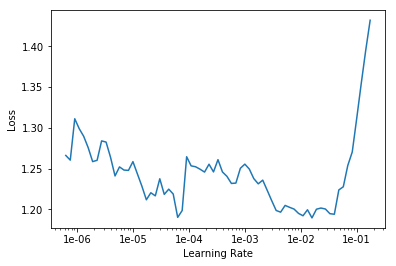

In [159]:
learn.recorder.plot()

In [160]:
lr = 2e-3

In [161]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,time
0,0.064659,0.046290,01:00
1,0.045685,0.031902,01:01


In [163]:
gpu_mem_get_free_no_cache()

7004

In [164]:
intep = learn.interpret(data_final)

In [170]:
mylosses = intep.losses
mylosses[:10]

tensor([8.1381e-02, 5.3222e-03, 1.9190e-01, 8.6311e-04, 1.6907e-02, 2.0262e-03,
        3.4844e-03, 1.4314e-05, 1.9390e-02, 9.2318e-03])

In [172]:
intep.top_losses(k = 10)

(tensor([1.0952, 1.0462, 0.9793, 0.9129, 0.8868, 0.8802, 0.8499, 0.8445, 0.8138,
         0.8113]),
 tensor([  374, 31982, 12342, 14303, 14297, 17485, 35662, 30238, 17483, 30699]))

In [ ]:
data_final.cla

In [173]:
intep.plot_top_losses(9)

AttributeError: classes

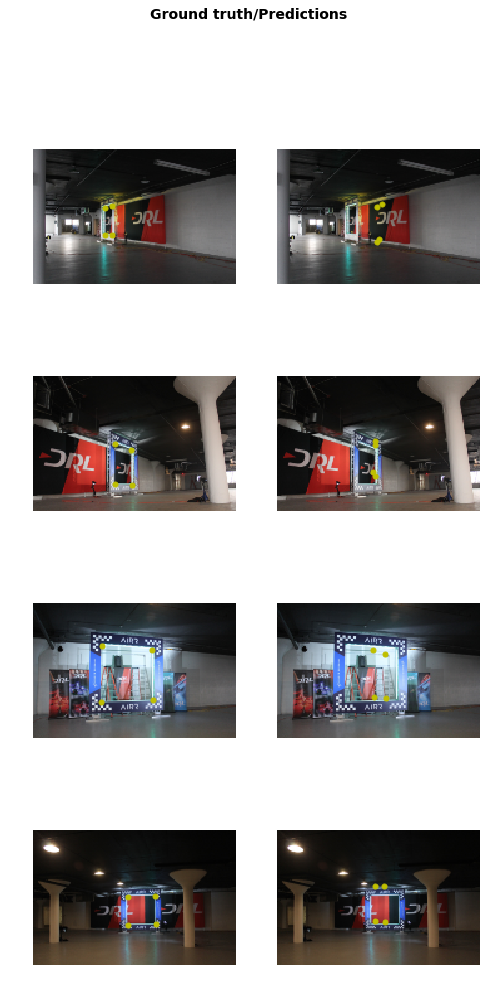

In [178]:
learn.show_results(s=100, c='y')

In [179]:
interp = ClassificationInterpretation.from_learner(learn)

In [180]:
interp.plot_top_losses(9)

AttributeError: classes

In [167]:
intep.plot_top_losses(9)

AttributeError: classes

##### Evaluate Model

In [145]:
pred_pts = learn.predict(img)
pred_pts

(ImagePoints (108, 162), tensor([[ 0.0328, -0.0811],
         [ 0.0589,  0.0406],
         [ 0.4386,  0.0388],
         [ 0.4119, -0.0849]]), tensor([ 0.0328, -0.0811,  0.0589,  0.0406,  0.4386,  0.0388,  0.4119, -0.0849]))

In [150]:
pred_pts

(ImagePoints (108, 162), tensor([[ 0.0328, -0.0811],
         [ 0.0589,  0.0406],
         [ 0.4386,  0.0388],
         [ 0.4119, -0.0849]]), tensor([ 0.0328, -0.0811,  0.0589,  0.0406,  0.4386,  0.0388,  0.4119, -0.0849]))

In [ ]:
pred_pts[0]

In [155]:
get_ip(pred_pts[0], pred_pts[1])

tensor([[ 0.0328, -0.0811],
        [ 0.0589,  0.0406],
        [ 0.4386,  0.0388],
        [ 0.4119, -0.0849]])

In [151]:
truth_pts

tensor([[453., 545.],
        [443., 720.],
        [635., 723.],
        [635., 545.]])

In [156]:
def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
#                        scale=True,  
#                        y_first=True
                      )
get_ip(img, pred_pts[1])

ImagePoints (864, 1296)

In [141]:
i = 1
i = np.random.randint(0, len(data_final.valid_dl.x.items) - 1)

fn =  data_final.valid_dl.x.items[i]
img = data_final.valid_dl.x.get(i)
truth_pts = data_final.valid_dl.y.items[i]

pred_pts = learn.predict(img)

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

print(i, fn.name)
print(pts)
img.show( y=get_ip(img, pred_pts)
         ,figsize=(10, 10)
         ,c='r'
         ,marker='+'
         ,s=100
         ,hide_axis=False
        )

1110 IMG_2337.JPG
tensor([[486., 584.],
        [473., 657.],
        [613., 661.],
        [615., 586.]])


TypeError: mul(): argument 'other' (position 1) must be Tensor, not tuple

In [ ]:
#do plot top losses

##### Others/Misc

In [ ]:
# verify that each corner is logically in-bounds + relative ot each other, "convex space"